In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import joblib
import pickle
import json

# ml frameworks
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

from catboost import CatBoostClassifier
#time management
from tqdm import tqdm

MultiClassification

In [ ]:
X_train_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/X_train_MC-III-50.csv")
X_val_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/X_val_MC-III-50.csv")
X_test_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/X_test_MC-III-50.csv")
y_train_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/y_train_MC-III-50.csv")
y_val_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/y_val_MC-III-50.csv")
y_test_csv = pd.read_csv("/content/drive/MyDrive/MC-III/AGORA/50/y_test_MC-III-50.csv")

In [ ]:
def to_npy(X_train_csv, X_val_csv, X_test_csv, y_train_csv, y_val_csv, y_test_csv):
    X_train = X_train_csv.to_numpy()
    X_val = X_val_csv.to_numpy()
    X_test = X_test_csv.to_numpy()
    y_train = y_train_csv.to_numpy()
    y_val = y_val_csv.to_numpy()
    y_test = y_test_csv.to_numpy()

    # Save the arrays as .npy files
    np.save("X_train.npy", X_train)
    np.save("X_val.npy", X_val)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_val.npy", y_val)
    np.save("y_test.npy", y_test)

    print("CSV onverted to .npy format.")


In [ ]:
to_npy(X_train_csv, X_val_csv, X_test_csv, y_train_csv, y_val_csv, y_test_csv)

CSV onverted to .npy format.


In [ ]:
train_list = ["X_train.npy", "X_val.npy", "X_test.npy", "y_train.npy", "y_val.npy", "y_test.npy"]

In [ ]:
def load(train_list):
    X_train = np.load(train_list[0])
    X_val = np.load(train_list[1])
    X_test = np.load(train_list[2])
    y_train = np.load(train_list[3])
    y_val = np.load(train_list[4])
    y_test = np.load(train_list[5])
    return X_train, X_val, X_test, y_train, y_val, y_test


def create_confusion_matrix(y_true, y_pred, class_labels):
    '''
    Description: Create a confusion matrix for multiclass classification.
    Arguments:
        y_true (array-like): Ground truth labels;
        y_pred (array-like): Predicted labels;
        class_labels (list): List of class names or indices.
    Outputs:
        pd.DataFrame: A confusion matrix as a pandas DataFrame.
    '''
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=[f"True {cls}" for cls in class_labels],
                         columns=[f"Predicted {cls}" for cls in class_labels])
    return cm_df


def score_metrics(y_true, y_pred, y_prob, average='weighted'):
    '''
    Description: Calculate various metrics for multiclass classification.
    Arguments:
        y_true (array-like): Ground truth labels;
        y_pred (array-like): Predicted labels;
        y_prob (array-like): Predicted probabilities for each class;
        average (str): Averaging method for metrics ('micro', 'macro', or 'weighted').
    Outputs:
        dict: A dictionary containing accuracy, ROC AUC, precision, recall, and F1.
    '''
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob, multi_class="ovo", average=average),
        "Precision": precision_score(y_true, y_pred, average=average),
        "Recall": recall_score(y_true, y_pred, average=average),
        "F1 Score": f1_score(y_true, y_pred, average=average),
    }
    return metrics

def plot_curves(y_true, y_prob, class_labels):
    '''
    Description: Plot ROC and PR curves for multiclass classification.
    Arguments:
        y_true (array-like): Ground truth labels;
        y_prob (array-like): Predicted probabilities for each class;
        class_labels (list): List of class names or indices.
    Outputs: ROC and PR curves for each class.
    '''
    # ROC Curve for each class
    for i, class_label in enumerate(class_labels):
        RocCurveDisplay.from_predictions(
            y_true == i, y_prob[:, i], name=f"Class {class_label}"
        )
        plt.title(f"ROC Curve for Class {class_label}")
        plt.show()

    # PR Curve for each class
    for i, class_label in enumerate(class_labels):
        PrecisionRecallDisplay.from_predictions(
            y_true == i, y_prob[:, i], name=f"Class {class_label}"
        )
        plt.title(f"Precision-Recall Curve for Class {class_label}")
        plt.show()



def train_val_and_test(models, X_train, y_train, X_val, y_val, X_test, y_test, seed, class_labels):
    """
    Trains and evaluates multiple models using train, validation, and test sets.
    Saves metrics, confusion matrices, ROC/PR curves, and a summary JSON file.

    Args:
        models (dict): Dictionary of models to evaluate.
        X_train, y_train: Training data.
        X_val, y_val: Validation data.
        X_test, y_test: Test data.
        seed (int): Random seed.
        class_labels (list): Class names.

    Returns:
        dict: Validation and test metrics for all models.
    """
    results = {}

    for model_name, model in tqdm(models.items(), desc="Training Models", unit="model"):
        print(f"\nTraining and evaluating: {model_name}")

        # Create storage directory
        model_dir = f"results/{model_name.replace(' ', '_')}"
        if os.path.exists(model_dir):
            shutil.rmtree(model_dir)
        os.makedirs(model_dir)

        # Train
        model.fit(X_train, y_train)

        # Save the model
        model_path = os.path.join(model_dir, "model.pkl")
        joblib.dump(model, model_path)

        # Validation
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val) if hasattr(model, "predict_proba") else model.decision_function(X_val)
        val_acc = np.mean(y_val_pred == y_val)
        val_auc = roc_auc_score(y_val, y_val_prob, multi_class="ovr", average="weighted")
        val_mcc = matthews_corrcoef(y_val, y_val_pred)

        # Test
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)
        test_acc = np.mean(y_test_pred == y_test)
        test_auc = roc_auc_score(y_test, y_test_prob, multi_class="ovr", average="weighted")
        test_mcc = matthews_corrcoef(y_test, y_test_pred)

        # Store metrics
        results[model_name] = {
            "Validation Accuracy": val_acc,
            "Validation ROC AUC": val_auc,
            "Validation MCC": val_mcc,
            "Test Accuracy": test_acc,
            "Test ROC AUC": test_auc,
            "Test MCC": test_mcc
        }

        # Save classification report
        report = classification_report(y_val, y_val_pred, target_names=class_labels)
        with open(os.path.join(model_dir, "classification_report.txt"), "w") as f:
            f.write(report)

        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.colorbar()
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels)
        plt.yticks(tick_marks, class_labels)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, "confusion_matrix.png"))
        plt.close()

    summary_path = "results/summary_metrics.json"
    with open(summary_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"\nJSON saved to: {summary_path}")

    print("\nValidation and Test Metrics (using MCC):")
    for model_name, metrics in results.items():
        print(
            f"{model_name}: "
            f"Val Accuracy = {metrics['Validation Accuracy']:.4f}, "
            f"Val MCC = {metrics['Validation MCC']:.4f}, "
            f"Test Accuracy = {metrics['Test Accuracy']:.4f}, "
            f"Test MCC = {metrics['Test MCC']:.4f}"
        )

    return results

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = load(train_list)

models = {
    "CatBoost": CatBoostClassifier(n_estimators=2000, random_state=42),
}

train_val_and_test(models, X_train, y_train, X_val, y_val, X_test, y_test, seed=4221, class_labels=["Competition",
           "Facultative Cooperation",
           "Obligate plusX cooperation",
           "Obligate xPlus cooperation",
           "Obligate XX Cooperation"])

Training Models:   0%|          | 0/1 [00:00<?, ?model/s]


Training and evaluating: CatBoost
Learning rate set to 0.061518
0:	learn: 1.5353084	total: 218ms	remaining: 7m 15s
1:	learn: 1.4757002	total: 448ms	remaining: 7m 27s
2:	learn: 1.4259082	total: 730ms	remaining: 8m 6s
3:	learn: 1.3835829	total: 962ms	remaining: 8m
4:	learn: 1.3474271	total: 1.19s	remaining: 7m 55s
5:	learn: 1.3156056	total: 1.44s	remaining: 7m 59s
6:	learn: 1.2878052	total: 1.67s	remaining: 7m 54s
7:	learn: 1.2628305	total: 1.92s	remaining: 7m 58s
8:	learn: 1.2409944	total: 2.09s	remaining: 7m 42s
9:	learn: 1.2209705	total: 2.33s	remaining: 7m 43s
10:	learn: 1.2031092	total: 2.54s	remaining: 7m 39s
11:	learn: 1.1872399	total: 2.75s	remaining: 7m 36s
12:	learn: 1.1720833	total: 3s	remaining: 7m 37s
13:	learn: 1.1588204	total: 3.2s	remaining: 7m 34s
14:	learn: 1.1463048	total: 3.51s	remaining: 7m 44s
15:	learn: 1.1349407	total: 3.88s	remaining: 8m 1s
16:	learn: 1.1245725	total: 4.24s	remaining: 8m 14s
17:	learn: 1.1149670	total: 4.57s	remaining: 8m 22s
18:	learn: 1.106466

In [ ]:
!pip install shap

In [ ]:
import shap

model = joblib.load("/content/results/CatBoost/model.pkl")

explainer = shap.TreeExplainer(model)
features = [
    "12ppd__R", "12ppd__S", "13ppd", "14glucan", "15dap", "23camp", "23ccmp", "23cgmp", "23cump",
    "23dappa", "23dhbzs3", "26dap__M", "2ddglcn", "2dhglcn", "2hxmp", "2obut", "2pg", "2pglyc",
    "34dhbz", "34dhcinm", "34dhpac", "3amp", "3cmp", "3gmp", "3hcinnm", "3hoxpac", "3hpp",
    "3hpppn", "3httdca", "3mb", "3oxoadp", "3pg", "3ump", "4abut", "4abz", "4crsol", "4hba",
    "4hbald", "4hbz", "4hoxpac", "4hoxpacd", "4hphac", "4hthr", "5dglcn", "5mtr", "6pgc",
    "LalaDgluMdapDala", "LalaDgluMdap", "LalaDglu", "LalaLglu", "Larab", "Lcyst", "T4hcinnm",
    "abt__L", "ac", "acac", "acald", "acgal1p", "acgal", "acgam1p", "acgam", "acmana", "acmum",
    "acnam", "acolipa", "acon_C", "acser", "actn__R", "acysbmn", "ad", "ade", "adn", "agm",
    "airs", "akg", "ala_B", "ala__D", "ala__L", "alaala", "all__D", "alltn", "amp", "amylose300",
    "anhgm", "arab__D", "arab__L", "araban__L", "arbt", "arbtn", "arbtn_fe3", "arg__L", "ascb__L",
    "asn__L", "aso3", "aso4", "asp__L", "bmn", "btd_RR", "btoh", "but", "buts", "butso3", "bz",
    "bzal", "bzalc", "ca2", "catechol", "cd2", "cell4", "cell500", "cell6", "cellb", "cgly",
    "chol", "chols", "chor", "chtbs", "cit", "citr__L", "cl", "cm", "cmp", "co2", "co", "coa",
    "cobalt2", "colipa", "colipap", "confrl", "cpgn", "cpgn_un", "crn", "cro4", "csn", "ctbt",
    "cu2", "cu", "cyan", "cynt", "cys__D", "cys__L", "cyst__L", "cytd", "dad_2", "damp", "dca",
    "dcmp", "dcyt", "ddca", "dextrin", "dgmp", "dgsn", "dha", "diact", "dimp", "din", "dms",
    "dmso", "dopa", "doxrbcn", "drib", "dtmp", "dump", "duri", "dxyl", "eca4colipa", "elao",
    "elar", "enlipa", "enter", "etha", "eths", "ethso3", "etoh", "f6p", "fald", "fe2", "fe3",
    "fe3dcit", "fe3dhbzs3", "fe3dhbzs", "fe3hox", "fe3hox_un", "fecrm", "fecrm_un", "feenter",
    "feoxam", "feoxam_un", "fer", "feroxB", "feroxBfe", "feroxE", "feroxEfe", "feroxG", "feroxGfe",
    "fol", "for", "frmd", "fru", "frulys", "fruur", "fuc__L", "fum", "fusa", "g1p", "g3pc", "g3pe",
    "g3pg", "g3pi", "g3ps", "g6p", "gal1p", "gal", "gal_bD", "galct__D", "galctn__D", "galctn__L",
    "galctr__D", "galman4", "galman600", "galman6", "galt", "galur", "gam6p", "gam", "gbbtn",
    "gdp", "glc__D", "glcman4", "glcman600", "glcman6", "glcn", "glcn__D", "glcr", "glcur1p",
    "glcur", "gln__L", "glu__D", "glu__L", "glucan1500", "glucan4", "glucan6", "glx", "gly",
    "glyald", "glyb", "glyc2p", "glyc3p", "glyc", "glyc__R", "glyclt", "glycogen1500", "glycogen",
    "gm1lipa", "gm1lipb", "gm2lipa", "gmp", "gsn", "gthox", "gthrd", "gtp", "gua", "guln__L",
    "h2", "h2co3", "h2o2", "h2o", "h2s", "h", "hacolipa", "halipa", "hco3", "hdca", "hdcea",
    "hexs", "hg2", "his__L", "hom__L", "hqn", "hxa", "hxan", "ibt", "icit", "id3acald", "idon__L",
    "ile__L", "imp", "indole", "inost", "ins", "isetac", "istnt", "k", "kdo2lipid4", "kdo2lipid4b",
    "lac__D", "lac__L", "lcts", "leu__L", "lipa", "lipa_cold", "lipb", "lipoate", "lmn2", "lmn30",
    "lys__L", "lyx__L", "m_xyl", "madg", "mal__D", "mal__L", "malt", "malthp", "malthx", "maltpt",
    "malttr", "maltttr", "man1p", "man6p", "man", "manb", "manglyc", "mantr", "manttr", "mbdg",
    "melib", "meoh", "met__L", "metox", "metox__R", "metsox_R__L", "metsox_S__L", "mg2", "mincyc",
    "minohp", "mmet", "mn2", "mn4", "mnl", "mobd", "mso3", "murein4p3p", "murein4p4p", "murein4px4p",
    "murein4px4px4p", "murein5p3p", "murein5p4p", "murein5p5p5p", "murein5p5p", "murein5px3p",
    "murein5px4p", "murein5px4px4p", "n2", "n2o", "na1", "nac", "ncam", "nh4", "ni2", "nmn", "no2",
    "no3", "no", "novbcn", "o16a4colipa", "o2", "oaa", "ocdca", "ocdcea", "octa", "omcho", "omchr",
    "omclo", "omclr", "orn", "orn__L", "orot", "oxa", "p_xyl", "pac", "pacald", "pala", "pdima",
    "peamn", "pep", "phdca", "phe__L", "pheme", "phenol", "pi", "pnto__R", "ppa", "ppal", "ppdima",
    "ppi", "ppoh", "pppn", "ppt", "pro__L", "progly", "psclys", "pser__D", "pser__L", "ptrc",
    "pullulan1200", "pydam", "pydx", "pydxn", "pyr", "quin", "r5p", "raffin", "rbt", "rfamp",
    "rib__D", "ribflv", "rmn", "rnam", "s", "salchs2", "salchs2fe", "salchs4", "salchs4fe",
    "salchsx", "salcn", "sbt__D", "ser__D", "ser__L", "skm", "so3", "so4", "spmd", "srb__L",
    "starch1200", "starch", "succ", "sucr", "sula", "sulfac", "tag__D", "tartr__D", "tartr__L",
    "taur", "tc4", "tc7", "tcb", "tcynt", "tet", "thm", "thr__L", "thrp", "thym", "thymd", "tma",
    "tmao", "tmp", "tol", "tre", "trp__L", "tsul", "ttdca", "ttdcea", "tton", "ttrcyc", "tym",
    "tyr__L", "tyrp", "u4", "u6", "uaagmda", "uacgam", "udcpdp", "udcpo5", "udcpp", "udpacgal",
    "udpg", "udpgal", "udpglcur", "ump", "ura", "urate", "urea", "uri", "v4", "v5", "val__L",
    "vanln", "vanlt", "xan", "xmp", "xtsn", "xyl3", "xyl__D", "xylan12", "xylan4", "xylan8",
    "xylb", "xylu__L", "zn2"
]
shap_values = explainer.shap_values(X_test)

CARVEME

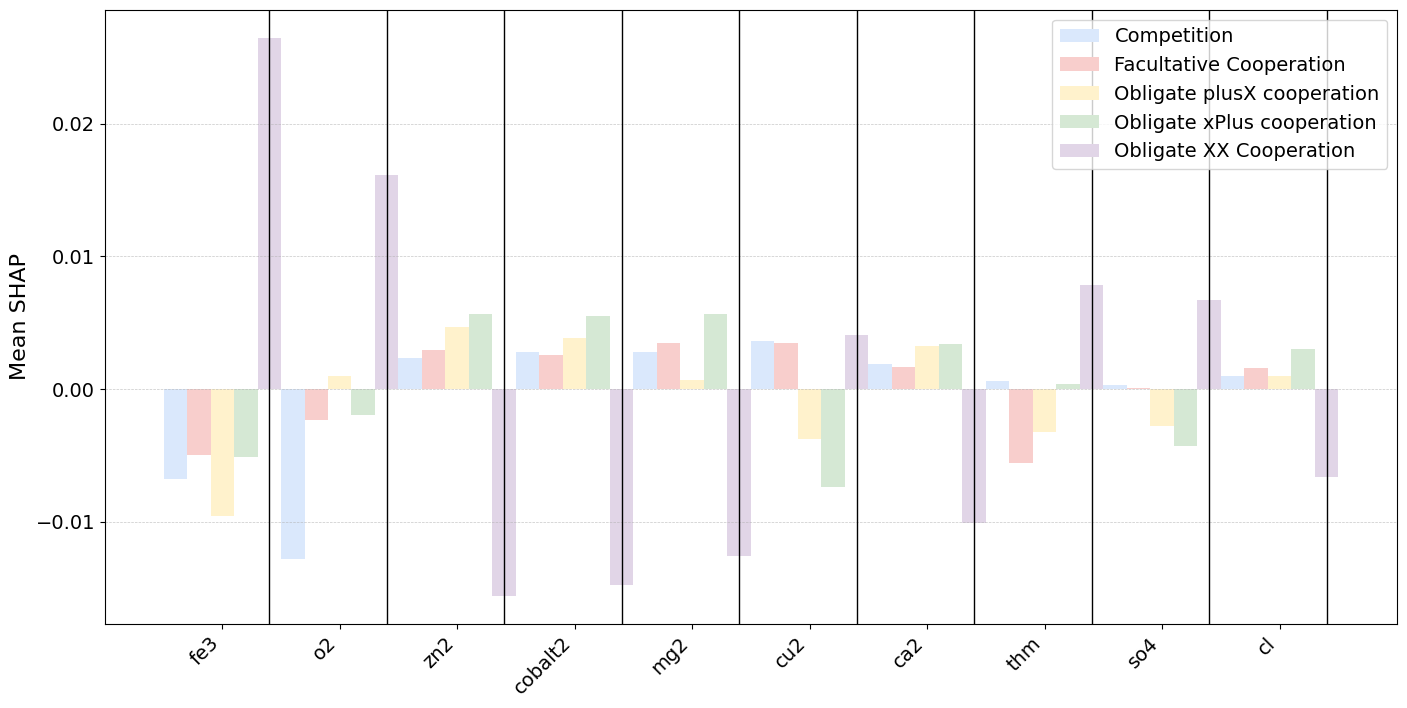

In [ ]:
mean_shap_values_per_class = np.mean(shap_values, axis=0)
feature_importance = np.sum(np.abs(mean_shap_values_per_class), axis=1)

# Get top 10 important features
top_10_indices = np.argsort(feature_importance)[-10:][::-1]
top_10_shap_values = mean_shap_values_per_class[top_10_indices, :]
top_10_features = [features[i] for i in top_10_indices]

classes = [
    "Competition",
    "Facultative Cooperation",
    "Obligate plusX cooperation",
    "Obligate xPlus cooperation",
    "Obligate XX Cooperation",
]

colors = ['#DAE8FC', '#F8CECC', '#FFF2CC', '#D5E8D4', '#E1D5E7']

# Create the bar plot
x = np.arange(len(top_10_features))
bar_width = 0.2
plt.figure(figsize=(14, 7))

for i, (class_label, color) in enumerate(zip(classes, colors)):
    plt.bar(
        x + i * bar_width,
        top_10_shap_values[:, i],
        bar_width,
        label=class_label,
        color=color
    )

for i in range(len(top_10_features)):
    plt.axvline(
        x=i + (len(classes) - 1) * bar_width,
        color='black',
        linestyle='-',
        linewidth=1
    )

# Formatting
plt.xticks(x + bar_width * (len(classes) - 1) / 2, top_10_features, rotation=45, ha="right")
plt.ylabel("Mean SHAP", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=14)
# Save the figure before showing it
plt.savefig("carveme_shap.png", dpi=300, bbox_inches='tight')
plt.show()


AGORA

In [ ]:
model = joblib.load("/content/results/CatBoost/model.pkl")

explainer = shap.TreeExplainer(model)
features = [
    "12dgr180", "12dhchol", "12ppd_S", "13ppd", "15dap", "26dap_M", "2ddglcn", "2dmmq8", "2hyoxplac",
    "2mbut", "2obut", "2omfuc", "2omxyl", "34dhpha", "34dhphe", "3ddlhept", "3dhcdchol", "3dhchol",
    "3hcinnm", "3hphac", "3hpppn", "3mop", "4abut", "4abz", "4hbz", "4hoxpacd", "4hphac", "4hpro_LT",
    "4mcat", "5aptn", "5htrp", "5mta", "5mthf", "7dhcdchol", "7ocholate", "C02528", "Cit_Mg", "HC00319",
    "HC02191", "HC02194", "Lcyst", "Lcystin", "Lkynr", "M03134", "Ser_Thr", "T_antigen", "Tn_antigen",
    "Tyr_ggn", "ac", "acac", "acald", "acerA", "acgal", "acgalglcur", "acgalidour2s", "acgalidour",
    "acgam", "acmana", "acnam", "actn_R", "adchac", "ade", "adn", "adocbl", "ahcys", "akg", "ala_D",
    "ala_L", "alaasp", "alagln", "alaglu", "alagly", "alahis", "alaleu", "alathr", "alchac", "alltn",
    "amet", "amp", "amylopect900", "amylose300", "apio_D", "arab_D", "arab_L", "arabinan101",
    "arabinogal", "arabinoxyl", "arabttr", "arbt", "arg_L", "arsenb", "asn_L", "aso3", "aso4", "asp_L",
    "bglc", "bhb", "btd_RR", "btn", "btoh", "but", "butso3", "ca2", "cbl1", "cbl2", "cd2", "cellb",
    "cellul", "cgly", "ch4", "ch4s", "chol", "cholate", "chols", "chor", "chsterol", "chtbs", "cinnm",
    "cit", "cl", "cmp", "co2", "coa", "cobalt2", "coprost", "core2", "core3", "core4", "core5", "core6",
    "core7", "core8", "crn", "cro4", "csn", "cspg_a", "cspg_a_degr", "cspg_ab_rest", "cspg_b",
    "cspg_b_degr", "cspg_c", "cspg_c_degr", "cspg_c_rest", "ctbt", "cu2", "cynt", "cys_L", "cytd",
    "dad_2", "datp", "dchac", "dcyt", "ddca", "dextran40", "dextrin", "dgchol", "dgsn", "dhcinnm",
    "dhpppn", "diact", "din", "dms", "dmso", "dopa", "dpcoa", "drib", "dsT_antigen", "dtmp", "dttp",
    "duri", "etha", "ethso3", "etoh", "f1a", "fald", "fe2", "fe3", "fecrm", "fol", "for", "fru",
    "fuc1p_L", "fuc_L", "fum", "g6p", "gal", "galct_D", "galctn_D", "galmannan", "galt", "galur",
    "gam26s", "gam", "gbbtn", "gcald", "gchola", "glc_D", "glcmannan", "glcn", "glcr", "glcur", "gln_L",
    "glu_L", "glutar", "gly", "glyasn", "glyasp", "glyb", "glyc3p", "glyc", "glyclt", "glycys", "glygln",
    "glyglu", "glygn2", "glygn4", "glygn5", "glyleu", "glymet", "glyphe", "glypro", "glytyr", "gncore1",
    "gncore2", "gsn", "gthox", "gthrd", "gtp", "gua", "h2", "h2o2", "h2o", "h2s", "h", "ha", "ha_deg1",
    "ha_pre1", "hco3", "hdca", "hexs", "hg2", "his_L", "hista", "hom_L", "homogal", "hspg", "hspg_degr_10",
    "hspg_degr_11", "hspg_degr_12", "hspg_degr_13", "hspg_degr_14", "hspg_degr_15", "hspg_degr_1",
    "hspg_degr_2", "hspg_degr_3", "hspg_degr_4", "hspg_degr_5", "hspg_degr_6", "hspg_degr_7",
    "hspg_degr_8", "hspg_degr_9", "hspg_rest", "hxan", "icdchol", "icit", "idon_L", "idour", "ile_L",
    "ind3ac", "ind3ppa", "indole", "indprp", "inost", "ins", "inulin", "isetac", "isobut", "isocapr",
    "isochol", "isoval", "ispre", "k", "kdo", "kesto", "kestopt", "kestottr", "lac_D", "lac_L", "lanost",
    "lcts", "leu_L", "levan1000", "levanb", "levanttr", "levantttr", "lichn", "lmn2", "lmn30", "lys_L",
    "lyx_L", "mal_L", "malt", "malthx", "malttr", "man6p", "man", "mannan", "mantr", "melib", "meoh",
    "met_D", "met_L", "metala", "metsox_R_L", "metsox_S_L", "mg2", "mn2", "mnl", "mobd", "mops", "mqn7",
    "mqn8", "mso3", "n2", "n2o", "na1", "nac", "nadp", "ncam", "nh4", "ni2", "nmn", "no2", "no3", "no",
    "o2", "oaa", "ocdca", "ocdcea", "orn", "oxa", "pac", "pb", "pcresol", "pect", "pecticgal", "ph2s",
    "phe_L", "pheme", "phenol", "phppa", "phpyr", "pi", "pime", "pnto_R", "ppa", "ppi", "pppn", "pro_L",
    "ptrc", "pullulan1200", "pydam", "pydx", "pydxn", "pyr", "q8", "r34hpp", "raffin", "rbflvrd",
    "rhamnogalurII", "rhamnogalurI", "rib_D", "ribflv", "rmn", "sT_antigen", "sTn_antigen", "salcn",
    "sbt_D", "sbt_L", "sel", "selni", "ser_D", "ser_L", "sheme", "so3", "so4", "spmd", "srtn", "starch1200",
    "strch1", "strch2", "stys", "succ", "sucr", "sulfac", "taur", "tchola", "tdchola", "tet", "thf",
    "thm", "thmmp", "thr_L", "thymd", "tma", "tmao", "tre", "trp_L", "trypta", "tsul", "ttdca", "tym",
    "tyr_L", "uchol", "ura", "urea", "uri", "val_L", "xan", "xtsn", "xyl_D", "xylan", "xyluglc", "zn2"
]
shap_values = explainer.shap_values(X_test)

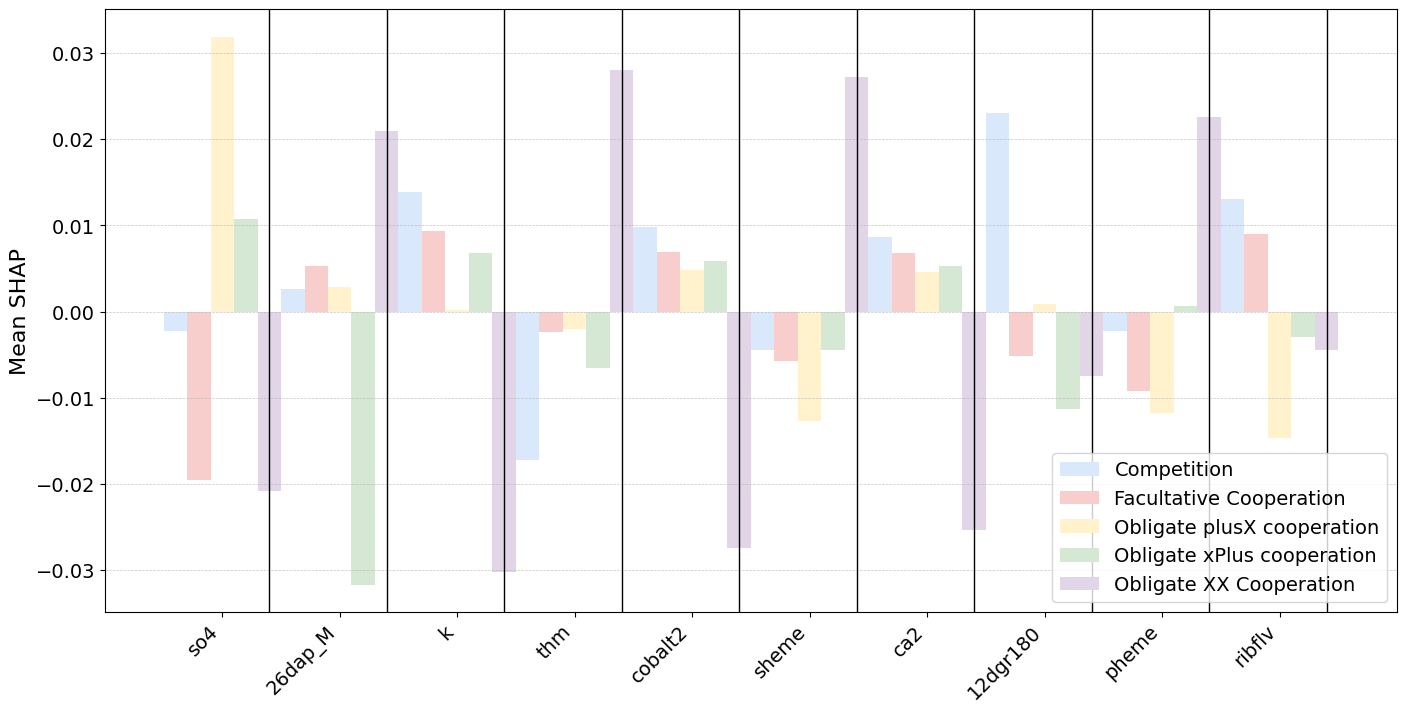

In [ ]:
mean_shap_values_per_class = np.mean(shap_values, axis=0)
feature_importance = np.sum(np.abs(mean_shap_values_per_class), axis=1)

# Get top 10 important features
top_10_indices = np.argsort(feature_importance)[-10:][::-1]
top_10_shap_values = mean_shap_values_per_class[top_10_indices, :]
top_10_features = [features[i] for i in top_10_indices]

classes = [
    "Competition",
    "Facultative Cooperation",
    "Obligate plusX cooperation",
    "Obligate xPlus cooperation",
    "Obligate XX Cooperation",
]

colors = ['#DAE8FC', '#F8CECC', '#FFF2CC', '#D5E8D4', '#E1D5E7']

# Create the bar plot
x = np.arange(len(top_10_features))
bar_width = 0.2
plt.figure(figsize=(14, 7))

for i, (class_label, color) in enumerate(zip(classes, colors)):
    plt.bar(
        x + i * bar_width,
        top_10_shap_values[:, i],
        bar_width,
        label=class_label,
        color=color
    )

for i in range(len(top_10_features)):
    plt.axvline(
        x=i + (len(classes) - 1) * bar_width,
        color='black',
        linestyle='-',
        linewidth=1
    )

# Formatting
plt.xticks(x + bar_width * (len(classes) - 1) / 2, top_10_features, rotation=45, ha="right")
plt.ylabel("Mean SHAP", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=14)
# Save the figure before showing it
plt.savefig("agora_shap.png", dpi=300, bbox_inches='tight')
plt.show()